In [25]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv('training_df.csv')

In [5]:
train_df.drop(columns=['Unnamed: 0'],inplace=True)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7278 entries, 0 to 7277
Data columns (total 21 columns):
best_match_score     7278 non-null float64
genre                7278 non-null object
is_presale           7278 non-null int64
max_tickets          7278 non-null object
num_markets          7278 non-null float64
sold_out             7278 non-null float64
subgenre             7278 non-null object
venue_name_left      7278 non-null object
popularity_left      7278 non-null float64
headliner            7278 non-null object
support              7278 non-null object
metro_area           7278 non-null object
short_title          7278 non-null object
average_price        7278 non-null float64
median_price         7278 non-null float64
lowest_price         7278 non-null float64
venue_name           7278 non-null object
venue_popularity     7278 non-null float64
general_admission    7278 non-null bool
popularity_right     7278 non-null float64
score                7278 non-null float64
dtyp

In [9]:
dummy_df = pd.get_dummies(train_df)

In [10]:
X = dummy_df.drop(columns= ['sold_out'])
y = dummy_df['sold_out']

In [11]:
train_x, test_x, train_y, test_y = train_test_split(X,y, random_state=42)

In [12]:
baseline = DummyClassifier()
baseline.fit(train_x, train_y)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [16]:
y_pred = baseline.predict(test_x)

In [17]:
accuracy_score(test_y,y_pred)

0.8373626373626374

In [19]:
roc_auc_score(test_y,y_pred)

0.49310913287174407

In [23]:
roc = pd.DataFrame(roc_curve(test_y,y_pred))

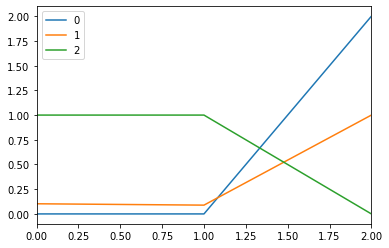

In [26]:
#plot roc curve
roc.plot()

In [61]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 5) 
tree_clf.fit(train_x, train_y)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [66]:
pred = tree_clf.predict(test_x)

print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(test_x, pred) * 100))

ValueError: Classification metrics can't handle a mix of unknown and binary targets

In [30]:
#random forest
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 10 decision trees
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)
# Train the model on training data
rf.fit(train_x, train_y);


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [35]:
clf = RandomForestClassifier()

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}


gs_tree = GridSearchCV(clf, param_grid, cv=3)
gs_tree.fit(train_x, train_y)

gs_tree.best_params_

{'max_features': 'sqrt', 'n_estimators': 200}

In [36]:
rf = RandomForestClassifier(criterion='entropy',n_estimators=200,max_features='sqrt')
rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
y_pred = rf.predict(test_x)

In [44]:
# rf gini
accuracy_score(test_y,y_pred)

0.9373626373626374

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


In [47]:
rfc_cv_score = cross_val_score(rf, X, y, cv=10, scoring='roc_auc')

In [50]:
print("=== Confusion Matrix ===")
print(confusion_matrix(test_y, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_y, y_pred))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[1667   18]
 [  96   39]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      1685
         1.0       0.68      0.29      0.41       135

    accuracy                           0.94      1820
   macro avg       0.81      0.64      0.69      1820
weighted avg       0.93      0.94      0.93      1820



=== All AUC Scores ===
[0.64382239 0.6468254  0.63478955 0.76927734 0.71111838 0.75737327
 0.71663837 0.71107203 0.68686636 0.63281591]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6910599007528833


In [54]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(train_x, train_y)
# print results
print(rfc_random.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 92.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 182.0min finished


{'n_estimators': 1800, 'max_features': 'auto', 'max_depth': 420}
